#Import

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

#Load data 24–25 (TRAIN)

In [2]:
train_df = pd.read_csv("Final_Matches(24-25).csv")

train_df = train_df.rename(columns={
    "homeTeamScore": "HG",
    "awayTeamScore": "AG"
})

train_df[["HG", "AG"]].head()

def get_result(row):
    if row["HG"] > row["AG"]:
        return "H"
    elif row["HG"] < row["AG"]:
        return "A"
    else:
        return "D"

train_df["Result"] = train_df.apply(get_result, axis=1)


#Goal averages (Poisson base rate)

In [3]:
league_home_goals = train_df["HG"].mean()
league_away_goals = train_df["AG"].mean()

#Attack / Defense (Standard Poisson)

In [4]:
teams = pd.unique(train_df[["HomeTeam", "AwayTeam"]].values.ravel())

team_stats = []

for team in teams:
    home = train_df[train_df["HomeTeam"] == team]
    away = train_df[train_df["AwayTeam"] == team]

    attack = (
        home["HG"].sum() + away["AG"].sum()
    ) / (league_home_goals * len(home) + league_away_goals * len(away))

    defense = (
        home["AG"].sum() + away["HG"].sum()
    ) / (league_away_goals * len(home) + league_home_goals * len(away))

    team_stats.append([team, attack, defense])

team_strengths = pd.DataFrame(
    team_stats, columns=["Team", "attack", "defense"]
).set_index("Team")


#Load fixtures 25–26

In [5]:
pred_df = pd.read_csv("Final_Macthes(25-26).csv")

In [6]:
pred_df = pred_df.rename(columns={
    "homeTeamScore": "HG",
    "awayTeamScore": "AG"
})

In [7]:
pred_df[["HG", "AG"]].head()

,HG,AG
0,4,2
1,0,0
2,1,1
3,3,0
4,3,0


In [8]:
pred_df.head()

,Round,Date,HomeTeam,AwayTeam,HG,AG
0,1,8/15/2025 20:00,Liverpool,AFC Bournemouth,4,2
1,1,8/16/2025 12:30,Aston Villa,Newcastle United,0,0
2,1,8/16/2025 15:00,Brighton & Hove Albion,Fulham,1,1
3,1,8/16/2025 15:00,Sunderland,West Ham United,3,0
4,1,8/16/2025 15:00,Tottenham Hotspur,Burnley,3,0


#Team promotion (SHRINKAGE)

In [9]:
teams_2425 = set(team_strengths.index)
teams_2526 = set(pred_df["HomeTeam"].unique())

promoted_teams = teams_2526 - teams_2425

avg_attack = team_strengths["attack"].mean()
avg_defense = team_strengths["defense"].mean()

SHRINK = 0.85

for team in promoted_teams:
    team_strengths.loc[team, "attack"] = avg_attack * SHRINK
    team_strengths.loc[team, "defense"] = avg_defense / SHRINK

#Calculate λ for each match

In [10]:
def get_team_strength(team, col):
    if team in team_strengths.index:
        return team_strengths.loc[team, col]
    else:
        return 1.0   # newly promoted teams

In [11]:
def compute_lambdas(row):
    home = row["HomeTeam"]
    away = row["AwayTeam"]

    lambda_home = (
        league_home_goals
        * get_team_strength(home, "attack")
        * get_team_strength(away, "defense")
    )

    lambda_away = (
        league_away_goals
        * get_team_strength(away, "attack")
        * get_team_strength(home, "defense")
    )

    return pd.Series([lambda_home, lambda_away])

In [12]:
pred_df = pred_df.copy()
pred_df[["lambda_home", "lambda_away"]] = pred_df.apply(
    compute_lambdas, axis=1
)

#Top-5 scorelines (CORE Poisson)

In [13]:
def top_scorelines(lh, la, max_goals=5, k=5):
    scores = []
    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            p = poisson.pmf(h, lh) * poisson.pmf(a, la)
            scores.append((h, a, p))
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:k]

pred_df["Top5Scores"] = pred_df.apply(
    lambda r: top_scorelines(r["lambda_home"], r["lambda_away"]),
    axis=1
)

#Outcome probabilities (H/D/A)

In [14]:
def outcome_probs(lh, la, max_goals=5):
    probs = {"H": 0, "D": 0, "A": 0}

    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            p = poisson.pmf(h, lh) * poisson.pmf(a, la)
            if h > a:
                probs["H"] += p
            elif h < a:
                probs["A"] += p
            else:
                probs["D"] += p
    return probs

pred_df["OutcomeProbs"] = pred_df.apply(
    lambda r: outcome_probs(r["lambda_home"], r["lambda_away"]),
    axis=1
)


#Evaluation dataframe

In [15]:
eval_df = pred_df.copy()

eval_df["ActualScore"] = eval_df["HG"].astype(str) + "-" + eval_df["AG"].astype(str)
eval_df["ActualResult"] = eval_df.apply(get_result, axis=1)

eval_df["PredictedResult"] = eval_df["OutcomeProbs"].apply(
    lambda d: max(d, key=d.get)
)

eval_df["MaxProb"] = eval_df["OutcomeProbs"].apply(
    lambda d: max(d.values())
)

eval_df["Correct"] = (
    eval_df["PredictedResult"] == eval_df["ActualResult"]
).astype(int)


TOP 5 COMPARISON TABLE

In [16]:
def top5_hit(row):
    actual = row["ActualScore"]
    preds = [f"{h}-{a}" for h, a, _ in row["Top5Scores"]]
    if actual in preds:
        return f"✅ Có (Top {preds.index(actual)+1})"
    return "❌ Không"

comparison_df = pd.DataFrame({
    "Trận đấu": eval_df["HomeTeam"] + " - " + eval_df["AwayTeam"],
    "Tỷ số thực": eval_df["ActualScore"],
    "Top 5 dự đoán": eval_df["Top5Scores"].apply(
        lambda x: ", ".join([f"{h}-{a}" for h,a,_ in x])
    ),
    "Trúng?": eval_df.apply(top5_hit, axis=1)
})

comparison_df

,Trận đấu,Tỷ số thực,Top 5 dự đoán,Trúng?
0,Liverpool - AFC Bournemouth,4-2,"1-1, 2-1, 1-0, 2-0, 3-1",❌ Không
1,Aston Villa - Newcastle United,0-0,"1-1, 1-2, 0-1, 2-1, 1-0",❌ Không
2,Brighton & Hove Albion - Fulham,1-1,"1-1, 2-1, 1-2, 1-0, 2-2",✅ Có (Top 1)
3,Sunderland - West Ham United,3-0,"1-1, 1-0, 2-1, 0-1, 1-2",❌ Không
4,Tottenham Hotspur - Burnley,3-0,"2-1, 1-1, 2-0, 2-2, 1-0",❌ Không
...,...,...,...,...
185,Manchester United - Wolverhampton Wanderers,1-1,"1-1, 1-0, 2-1, 0-1, 1-2",✅ Có (Top 1)
186,Crystal Palace - Fulham,1-1,"1-1, 1-0, 0-1, 2-1, 1-2",✅ Có (Top 1)
187,Liverpool - Leeds United,0-0,"2-0, 3-0, 2-1, 3-1, 1-0",❌ Không
188,Brentford - Tottenham Hotspur,0-0,"2-1, 1-1, 2-2, 1-2, 3-1",❌ Không


#distribution of goals

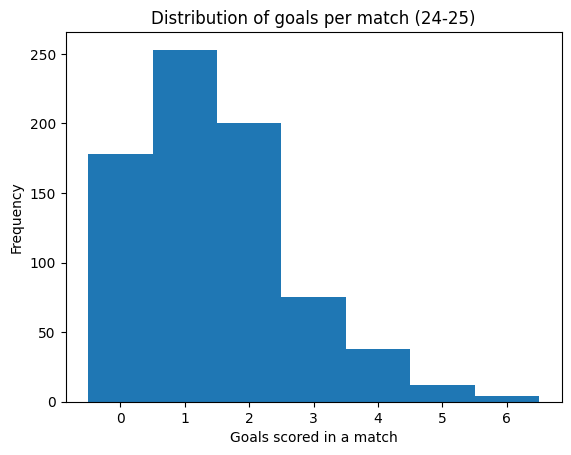

In [17]:
goals = pd.concat([
    train_df["HG"],
    train_df["AG"]
])

plt.figure()
plt.hist(goals, bins=range(0,8), align="left")
plt.xlabel("Goals scored in a match")
plt.ylabel("Frequency")
plt.title("Distribution of goals per match (24-25)")
plt.show()

#Comparison of true distribution and Poisson frit distribution

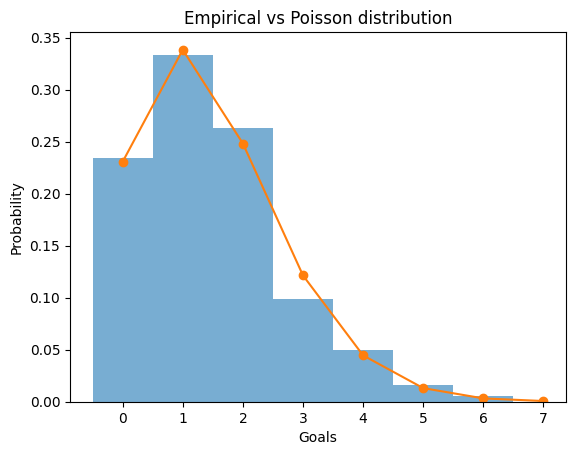

In [18]:
from scipy.stats import poisson
import numpy as np

mean_goals = goals.mean()
x = np.arange(0,8)
pmf = poisson.pmf(x, mean_goals)

plt.figure()
plt.hist(goals, bins=range(0,8), density=True, align="left", alpha=0.6)
plt.plot(x, pmf, marker="o")
plt.xlabel("Goals")
plt.ylabel("Probability")
plt.title("Empirical vs Poisson distribution")
plt.show()

#Heatmap

In [19]:
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
row = pred_df[
    (pred_df["HomeTeam"] == "Manchester United") &
    (pred_df["AwayTeam"] == "Arsenal")
].iloc[0]

home = row["HomeTeam"]
away = row["AwayTeam"]
lambda_home_example = row["lambda_home"]
lambda_away_example = row["lambda_away"]

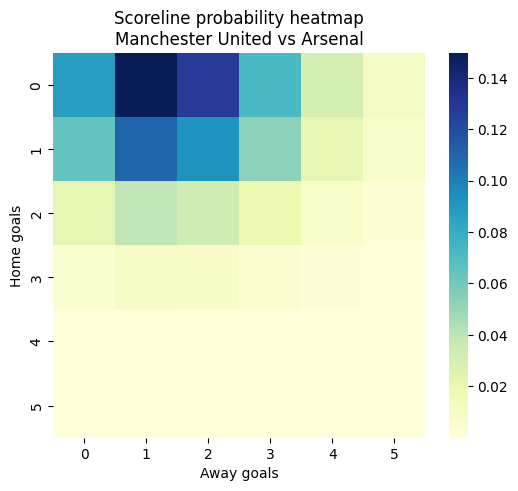

In [21]:
max_goals = 6
home_goals = np.arange(0, max_goals)
away_goals = np.arange(0, max_goals)

prob_matrix = np.outer(
    poisson.pmf(home_goals, lambda_home_example),
    poisson.pmf(away_goals, lambda_away_example)
)

plt.figure(figsize=(6,5))
sns.heatmap(
    prob_matrix,
    xticklabels=away_goals,
    yticklabels=home_goals,
    cmap="YlGnBu"
)
plt.xlabel("Away goals")
plt.ylabel("Home goals")
plt.title(f"Scoreline probability heatmap\n{home} vs {away}")
plt.show()

Hit@K (Top-5 accuracy)

In [22]:
from scipy.stats import poisson
import numpy as np

In [23]:
def compute_true_rank(row, max_goals=6):
    lambda_h = row["lambda_home"]
    lambda_a = row["lambda_away"]

    true_score = (row["HG"], row["AG"])

    home_goals = np.arange(0, max_goals)
    away_goals = np.arange(0, max_goals)

    probs = []
    for h in home_goals:
        for a in away_goals:
            p = poisson.pmf(h, lambda_h) * poisson.pmf(a, lambda_a)
            probs.append(((h, a), p))

    probs.sort(key=lambda x: x[1], reverse=True)

    for rank, (score, _) in enumerate(probs, start=1):
        if score == true_score:
            return rank

    return np.nan

In [24]:
eval_df = eval_df.copy()
eval_df["TrueRank"] = eval_df.apply(compute_true_rank, axis=1)

In [25]:
hit1 = (eval_df["TrueRank"] == 1).mean()
hit3 = (eval_df["TrueRank"] <= 3).mean()
hit5 = (eval_df["TrueRank"] <= 5).mean()

hit1, hit3, hit5

(np.float64(0.12631578947368421),
 np.float64(0.32105263157894737),
 np.float64(0.46842105263157896))

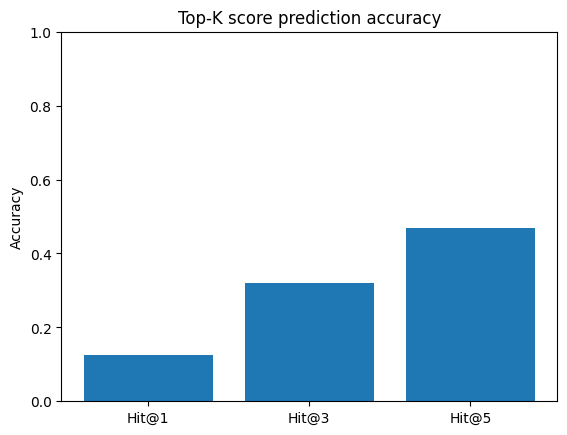

In [26]:
hits = {
    "Hit@1": hit1,
    "Hit@3": hit3,
    "Hit@5": hit5
}

plt.figure()
plt.bar(hits.keys(), hits.values())
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Top-K score prediction accuracy")
plt.show()

In [27]:
print(f"Hit@1: {hit1*100:.1f}%")
print(f"Hit@3: {hit3*100:.1f}%")
print(f"Hit@5: {hit5*100:.1f}%")

Hit@1: 12.6%
Hit@3: 32.1%
Hit@5: 46.8%
